In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import furniture_bench
import torch
import torchvision
import collections

import numpy as np
from tqdm import tqdm, trange
from ipdb import set_trace as bp

from src.gym import get_env
from src.models.actor import ImageActor, DoubleImageActor


from src.models.unet import ConditionalUnet1D
from src.models.vision import DinoEncoder
import matplotlib.pyplot as plt

from src.data.dataset import FurnitureImageDataset, SimpleFurnitureDataset

# Import IPython's embeddable shell
from IPython import embed

Importing module 'gym_38' (/home/azureuser/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/azureuser/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


/anaconda/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from ml_collections import ConfigDict


config = ConfigDict(
    dict(
        pred_horizon=16,
        obs_horizon=2,
        action_horizon=8,
        down_dims=[256, 512, 1024],
        num_epochs=2_000,
        num_diffusion_iters=100,
        beta_schedule="squaredcos_cap_v2",
        clip_sample=True,
        prediction_type="epsilon",
        actor_lr=1e-5,
        weight_decay=1e-6,
        lr_scheduler_type="cosine",
        lr_scheduler_warmup_steps=500,
        dataloader_workers=24,
        inference_steps=10,
        mixed_precision=True,
        clip_grad_norm=False,
        furniture="one_leg",
        observation_type="feature",
        demo_source="sim",
        vision_encoder="dinov2-base",
        num_envs=8,
        rollout_max_steps=20,
        n_rollouts=2,
    )
)

In [4]:
env = get_env(
    gpu_id=0,
    obs_type="image",
    furniture="one_leg",
    num_envs=config.num_envs,
    randomness='high',
)

PyTorch version 2.0.1+cu117
Device count 1
/home/azureuser/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/azureuser/.cache/torch_extensions/py38_cu117 as PyTorch extensions root...
Emitting ninja build file /home/azureuser/.cache/torch_extensions/py38_cu117/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
Using SDF cache directory '/home/azureuser/.isaacgym/sdf_V100'
~!~!~! Loaded/Cooked SDF triangle mesh 0 @ 0x83460b70, resolution=512, spacing=0.000317
  ~!~! Bounds:  (-0.081250, 0.081250) (-0.015685, 0.015565) (-0.081250, 0.081251)
  ~!~! Extents: (0.162500, 0.031250, 0.162501)
  ~!~! Resolution: (512, 99, 512)
~!~!~! Loaded/Cooked SDF triangle mesh 1 @ 0x830e4690, resolution=512, spacing=0.000171
  ~!~! Bounds:  (-0.015000, 0.015000) (-0.056250, 0.031250) (-0.014383, 0.015618)
  ~!~! Extents: (0.030000, 0.087500, 0.030001)
  ~!~! Resolution: (176, 512, 176)
~!~!~! Loaded/Cooked SDF triangle mesh 2 @ 0x84d25970, resolution=512, spacing=0.000172
  ~!~! Bounds:  (-0.015000, 0.015000) (-0.056562, 0.031376) (-0.015438, 0.014563)
  ~!~! Extents: (0.030000, 0.087938, 0.030001)
  ~!~! Resolution: (175, 512, 175)
~!~!~! Loaded/Cooked SDF triangle mesh 3 @ 0x85600ec0, resolution=512, spa

In [5]:
dataset = SimpleFurnitureDataset(
    dataset_path="/home/larsankile/furniture-diffusion/data/processed/sim/feature/dinov2-base/data.zarr",
    pred_horizon=config.pred_horizon,
    obs_horizon=config.obs_horizon,
    action_horizon=config.action_horizon,
)

config.action_dim = dataset.action_dim

PathNotFoundError: nothing found at path ''

In [6]:
# Print all dtypes in the dataset stats
print("Dataset dtypes:")
for k, v in dataset.stats.items():
    for kk, vv in v.items():
        print(f"{k} {kk}: {vv.dtype}")

Dataset dtypes:
action min: float32
action max: float32
obs min: float32
obs max: float32


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = DinoEncoder(size="base", freeze=True, device=device)

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=8,
    global_cond_dim=1_550 * 2,
    down_dims=[256, 512, 1024],
).to(device)

actor = ImageActor(noise_pred_net, enc, config, dataset.stats)

number of parameters: 1.096622e+08
stats tensor dtypes
obs min: torch.float32
obs max: torch.float32
action min: torch.float32
action max: torch.float32


In [8]:
# Print the dtypes of the models
print("Encoder dtype: ", next(enc.parameters()).dtype)
print("Noise pred net dtype: ", next(noise_pred_net.parameters()).dtype)

Encoder dtype:  torch.float32
Noise pred net dtype:  torch.float32


In [9]:
def rollout():
    obs = env.reset()

    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * 2,
        maxlen=2,
    )

    print(obs["color_image1"].shape)
    print(obs["color_image1"].dtype)

    plt.imshow(obs["color_image1"][0].cpu().numpy())
    plt.show()

    plt.imshow(obs["color_image2"][0].cpu().numpy())
    plt.show()
    raise ValueError("stop")

    # save visualization and rewards
    imgs1 = [obs["color_image1"]]
    imgs2 = [obs["color_image2"]]
    rewards = list()
    done = torch.BoolTensor([False] * 4)
    step_idx = 0

    with tqdm(
        total=100,
        desc="Eval OneLeg State Env",
        disable=True,
    ) as pbar:
        while not done.all():
            # Get the next actions from the actor
            with torch.no_grad():
                action_pred = actor.action(obs_deque)

            # only take action_horizon number of actions
            start = config.obs_horizon - 1
            end = start + config.action_horizon
            action = action_pred[:, start:end, :]
            # (action_horizon, action_dim)

            # execute action_horizon number of steps
            # without replanning
            for i in range(action.shape[1]):
                # stepping env
                # bp()
                obs, reward, done, _ = env.step(action[:, i, :])

                # save observations
                obs_deque.append(obs)

                # and reward/vis
                rewards.append(reward)
                imgs1.append(obs["color_image1"])
                print('obs["color_image1"].shape', obs["color_image1"].shape)
                imgs2.append(obs["color_image2"])
                print('obs["color_image2"].shape', obs["color_image2"].shape)

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
                ax1.imshow(obs["color_image1"][0].cpu().numpy())
                ax2.imshow(obs["color_image2"][1].cpu().numpy())
                plt.show()

                break
                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(reward=reward)
                if step_idx >= config.rollout_max_steps:
                    done = torch.BoolTensor([True] * config.num_envs)

                if done.all():
                    break

    return (
        torch.cat(rewards, dim=1),
        torch.stack(imgs1).transpose(0, 1),
        torch.stack(imgs2).transpose(0, 1),
    )

color_image1 torch.Size([224, 224, 4])
color_image2 torch.Size([224, 224, 4])
torch.Size([4, 224, 224, 3])
torch.uint8


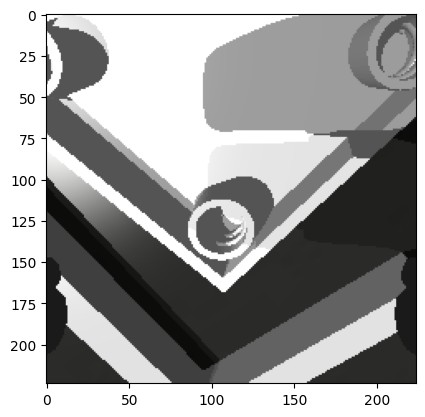

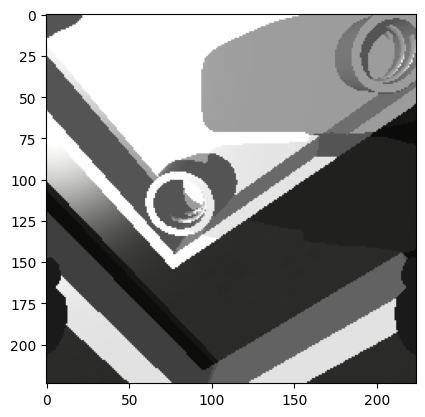

ValueError: stop

In [10]:
n_success = 0
all_rewards = list()
all_imgs1 = list()
all_imgs2 = list()

for _ in range(config.n_rollouts):
    # Perform a rollout with the current model
    rewards, imgs1, imgs2 = rollout()

    # Update progress bar
    success = rewards.sum(dim=1) > 0
    n_success += success.sum().item()

    # Save the results from the rollout
    all_rewards.append(rewards)
    all_imgs1.append(imgs1)
    all_imgs2.append(imgs2)

# Combine the results from all rollouts into a single tensor
all_rewards = torch.cat(all_rewards, dim=0)
all_imgs1 = torch.cat(all_imgs1, dim=0)
all_imgs2 = torch.cat(all_imgs2, dim=0)

videoes = list()

for rollout_idx in range(config.n_rollouts):
    # Get the rewards and images for this rollout
    rewards = all_rewards[rollout_idx].cpu().numpy()
    video1 = all_imgs1[rollout_idx].cpu().numpy()
    video2 = all_imgs2[rollout_idx].cpu().numpy()

    # Stack the two videoes side by side into a single video
    # and swap the axes from (T, H, W, C) to (T, C, H, W)
    video = np.concatenate([video1, video2], axis=2).transpose(0, 3, 1, 2)
    videoes.append(video)
    success = (rewards.sum() > 0).item()

In [ ]:
all_rewards.shape, all_imgs1.shape, all_imgs2.shape, len(videoes), videoes[0].shape

(torch.Size([8, 20]),
 torch.Size([8, 21, 224, 224, 3]),
 torch.Size([8, 21, 224, 224, 3]),
 2,
 (21, 3, 224, 448))

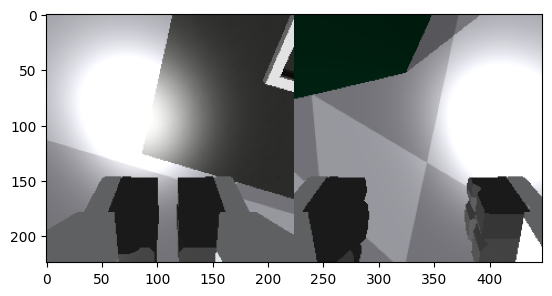

In [ ]:
plt.imshow(video[20].transpose(1, 2, 0))

In [ ]:
import cv2
import numpy as np
from IPython.display import HTML

# Create a VideoCapture object, here assuming 'output.avi' as output file name
fourcc = cv2.VideoWriter_fourcc(*"XVID")
out = cv2.VideoWriter("output.avi", fourcc, 10.0, (224, 224 * 2))

# Assuming 'frames' is your numpy array with shape (time, H, W, C)
for frame in videoes[0].transpose(0, 2, 3, 1):
    out.write(frame)

out.release()

# Embed video in notebook
HTML(
    """
<video width="640" height="480" controls>
  <source src="output.avi" type="video/mp4">
</video>
"""
)

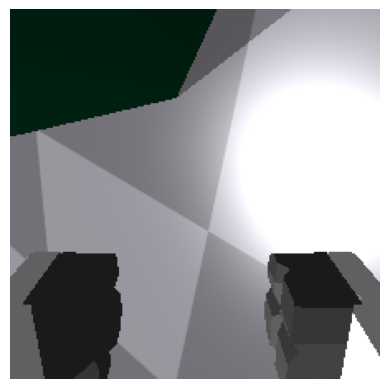

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Assuming 'frames' is your numpy array with shape (time, H, W, C)
for frame in video2:
    plt.imshow(frame)
    plt.axis("off")
    display(plt.gcf())
    clear_output(wait=True)

In [6]:
obs = env.reset()

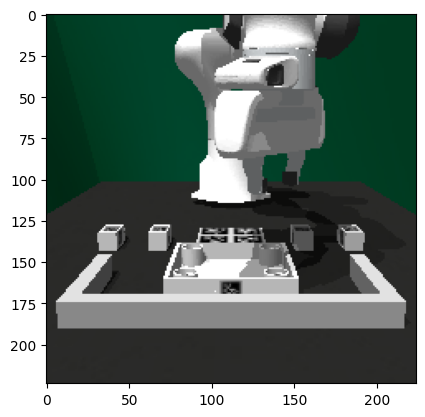

In [7]:
plt.imshow(obs["color_image2"][4].cpu().numpy())

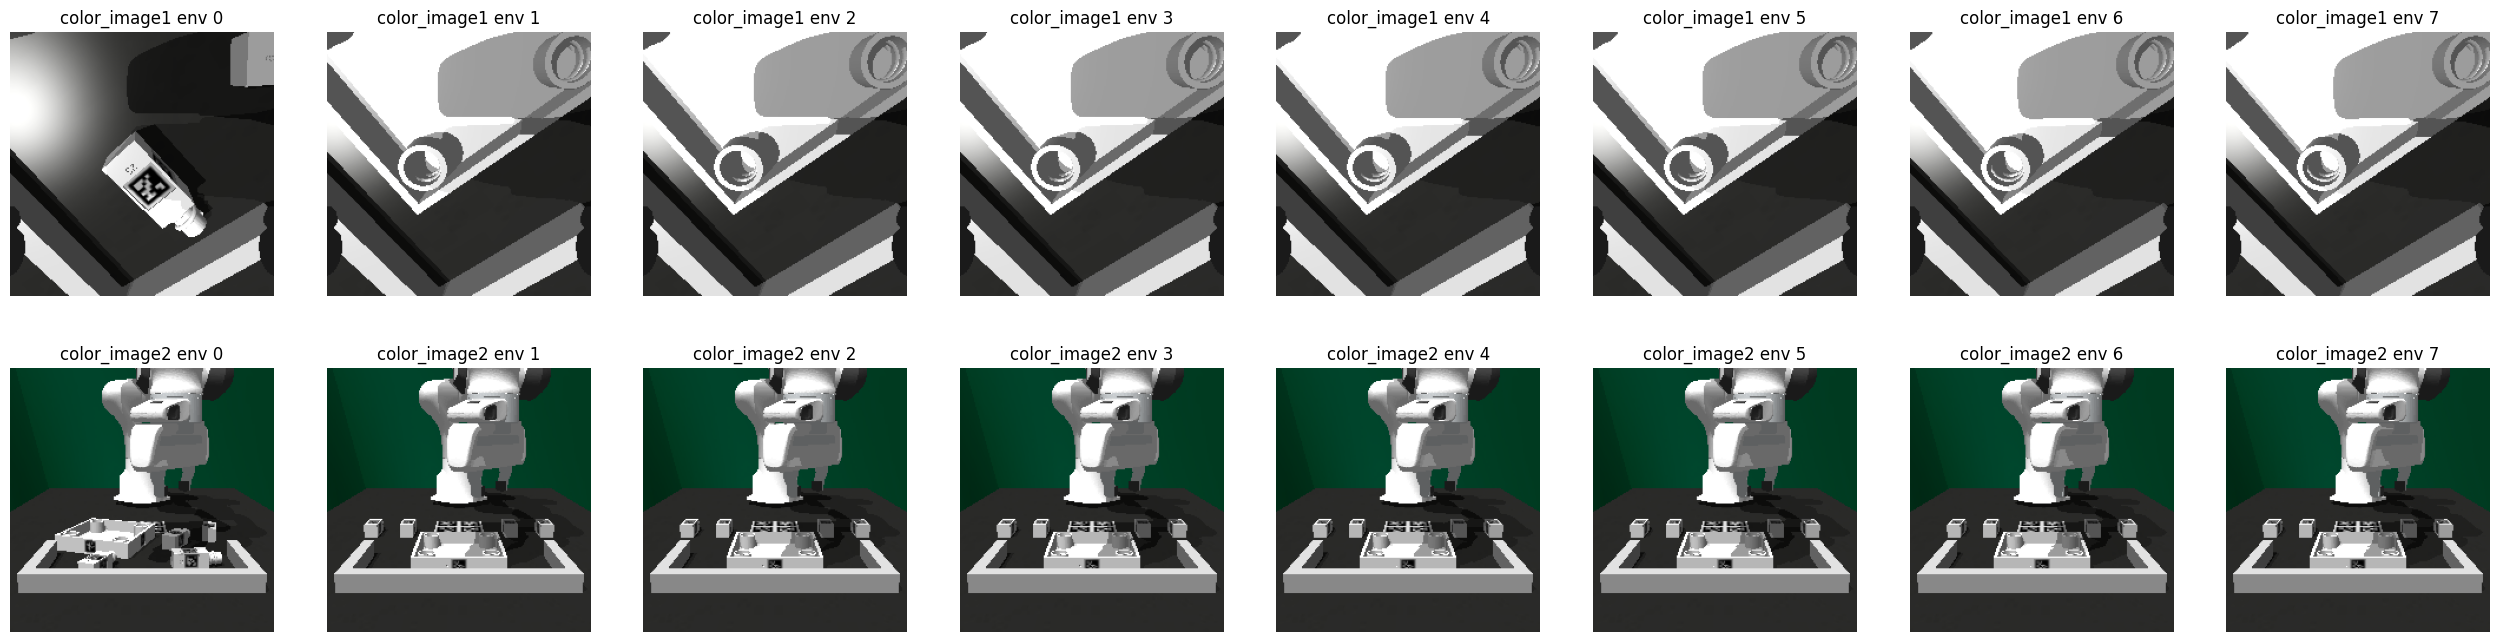

In [8]:
from itertools import product


fig, axs = plt.subplots(2, config.num_envs, figsize=(4 * config.num_envs, 8))

plt.imshow(env.camera_obs["color_image2"][3][..., :-1].cpu().numpy())

for ax, (i, e) in zip(axs.flatten(), product(range(1, 3), range(config.num_envs))):
    ax.imshow(env.camera_obs[f"color_image{i}"][e][..., :-1].cpu().numpy())
    ax.set_title(f"color_image{i} env {e}")
    ax.axis("off")

In [9]:
norm = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

In [7]:
# Make a fake image of random ints from 0 to 255
img = torch.randint(0, 255, (224, 224, 3)) / 255

# Convert to float and normalize
norm(img).shape

RuntimeError: The size of tensor a (224) must match the size of tensor b (3) at non-singleton dimension 0

In [12]:
act = DoubleImageActor("cuda", "18", config, dataset.stats)

AttributeError: 'str' object has no attribute 'parameters'